# Import necessary packages

In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Plot of closing price

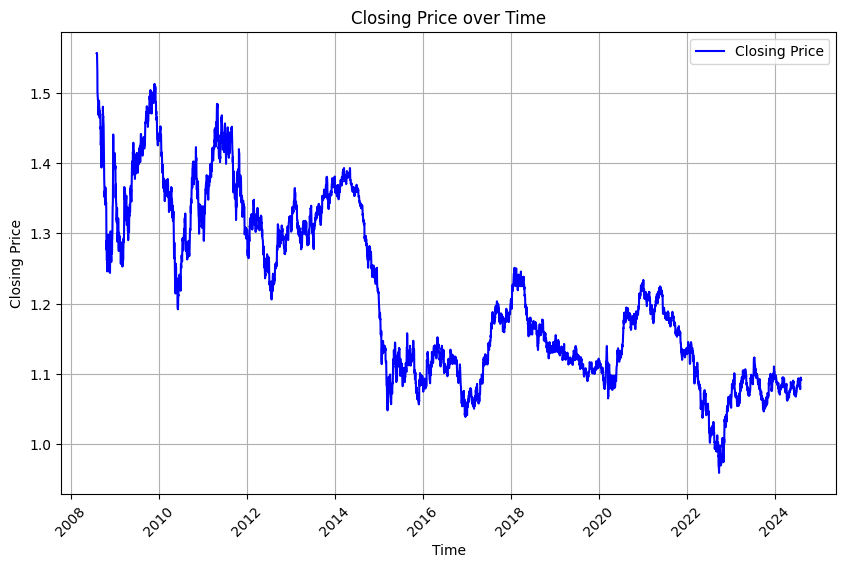

In [74]:
file_path = './Data/EURUSD_D1.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')
# data= data.set_index('Time', inplace=True)
statData = data # for statistical analysis

# Extract Time and Close columns
time_data = data['Time'].values  # Numpy array of time values
close_data = data['Close'].values  # Numpy array of closing prices

# Optionally, convert the closing prices to a PyTorch tensor
close_tensor = torch.tensor(close_data, dtype=torch.float32)

# Plot the closing price over time using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(time_data, close_tensor, label="Closing Price", color='blue', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Closing Price over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend()
plt.show()

# Stationarity test

In [56]:
from statsmodels.tsa.stattools import adfuller
adf,pvalue,usedlag_, nobs_, critical_values, icbest_ = adfuller(data.iloc[:, -2])
if pvalue >0.05:
    print(f'p-value = {pvalue}. \nClosing price data is NOT stationary')
else:
    print(f'p-value = {pvalue}. \nData is stationary')

#Weak stationarity?


p-value = 0.06046931425545568. 
Closing price data is NOT stationary


# Data Exploration? Boxplot, see year trend, seasonality per quarter, etc

               Open     High      Low    Close    Volume
Time                                                    
2024-07-21  1.08861  1.09027  1.08807  1.08988   13131.0
2024-07-22  1.08988  1.08998  1.08730  1.08889  192600.0
2024-07-23  1.08888  1.08967  1.08438  1.08496  189398.0
2024-07-24  1.08495  1.08664  1.08256  1.08378  228205.0
2024-07-25  1.08379  1.08699  1.08282  1.08513  274997.0
2024-07-26  1.08514  1.08681  1.08420  1.08547  162991.0
2024-07-27      NaN      NaN      NaN      NaN       NaN
2024-07-28  1.08553  1.08599  1.08527  1.08527    8309.0
2024-07-29  1.08524  1.08700  1.08028  1.08190  164236.0
2024-07-30  1.08191  1.08356  1.07982  1.08157  197098.0
2024-07-31  1.08156  1.08493  1.08019  1.08238  310176.0
2024-08-01  1.08235  1.08354  1.07774  1.07864  315513.0
2024-08-02  1.07864  1.09265  1.07818  1.09098  359862.0
2024-08-03      NaN      NaN      NaN      NaN       NaN
2024-08-04  1.09225  1.09234  1.09028  1.09103   18972.0
2024-08-05  1.09104  1.10088  1

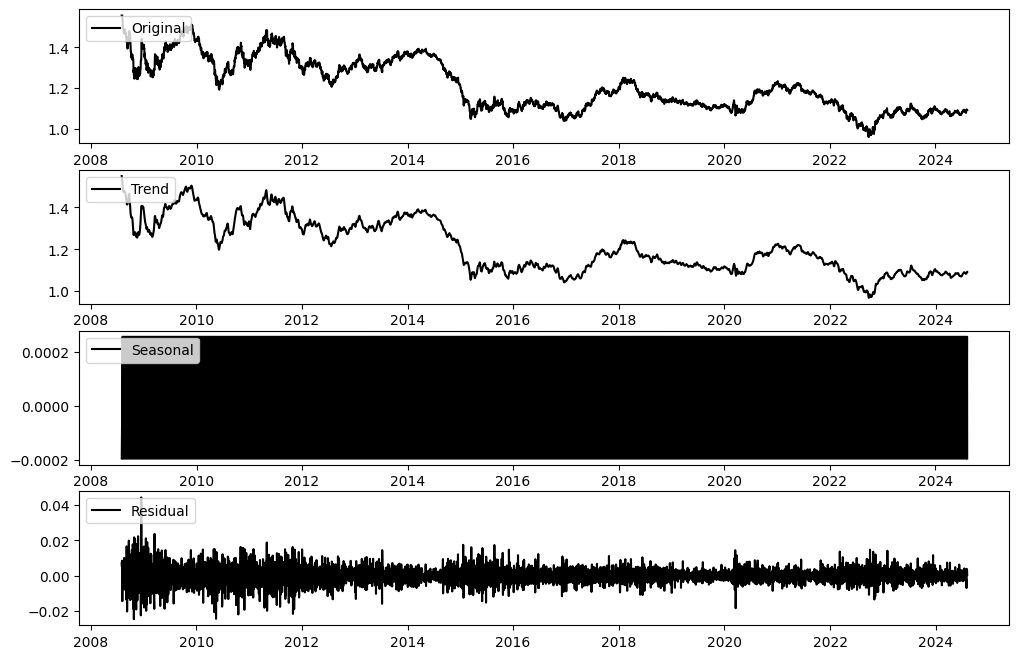

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the data
file_path = './Data/EURUSD_D1.csv'  # Replace with your actual file path
statData = pd.read_csv(file_path)

# Convert 'Time' column to datetime and set it as the index
statData['Time'] = pd.to_datetime(statData['Time'], format='%Y-%m-%d %H:%M:%S')
statData.set_index('Time', inplace=True)

# Set frequency to daily
statData = statData.asfreq('D') #change frequency , weekly and Monthly

print(statData.tail(20))

statData['Close'].fillna(method='ffill', inplace=True)  # Forward fill missing data

# Decompose the time series
decomposed = seasonal_decompose(statData['Close'], model='additive')

# Extract trend, seasonal, and residual components
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(statData['Close'], label='Original', color='black')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', color='black')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='black')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residual', color='black')
plt.legend(loc='upper left')

plt.show()


# Data loader

In [50]:
# Data Loader
class ForexDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)         # Load the dataset

        n_past = 5
        self.features = []
        self.labels= []

        for i in range(n_past, len(self.data)):
            self.features.append(self.data.iloc[i-n_past:i, -2].values)  # Select n_past number of rows for the closing price
            self.labels.append(self.data.iloc[i, -2])  # The target value
 
    def __len__(self):
        return len(self.features)  # Return the number of samples
    
    def __getitem__(self, idx):
        # Get the features and labels as tensors
        feature = torch.tensor(self.features[idx], dtype=torch.float64)
        label = torch.tensor(self.labels[idx], dtype=torch.float64)

        return feature, label

# Loading the dataset and creating the dataloader
file_path = './Data/EURUSD_D1.csv'  # Replace with your actual file path
dataset = ForexDataset(file_path)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False) # Create DataLoader for batch processing - will load batches of data


for batch_idx, (features, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"Features: {features}")
    print(f"Labels (Next Close Price): {labels}")



Batch 1
Features: tensor([[1.5561, 1.5566, 1.5564, 1.5464, 1.5419],
        [1.5566, 1.5564, 1.5464, 1.5419, 1.5311],
        [1.5564, 1.5464, 1.5419, 1.5311, 1.5003],
        [1.5464, 1.5419, 1.5311, 1.5003, 1.4932],
        [1.5419, 1.5311, 1.5003, 1.4932, 1.4912],
        [1.5311, 1.5003, 1.4932, 1.4912, 1.4891],
        [1.5003, 1.4932, 1.4912, 1.4891, 1.4896],
        [1.4932, 1.4912, 1.4891, 1.4896, 1.4773],
        [1.4912, 1.4891, 1.4896, 1.4773, 1.4686],
        [1.4891, 1.4896, 1.4773, 1.4686, 1.4699],
        [1.4896, 1.4773, 1.4686, 1.4699, 1.4694],
        [1.4773, 1.4686, 1.4699, 1.4694, 1.4791],
        [1.4686, 1.4699, 1.4694, 1.4791, 1.4750],
        [1.4699, 1.4694, 1.4791, 1.4750, 1.4887],
        [1.4694, 1.4791, 1.4750, 1.4887, 1.4791],
        [1.4791, 1.4750, 1.4887, 1.4791, 1.4781],
        [1.4750, 1.4887, 1.4791, 1.4781, 1.4724],
        [1.4887, 1.4791, 1.4781, 1.4724, 1.4643],
        [1.4791, 1.4781, 1.4724, 1.4643, 1.4743],
        [1.4781, 1.4724, 1.4643,

# FNN Model

[(tensor([1.5561, 1.5566, 1.5564, 1.5464, 1.5419]), tensor(1.5311)), (tensor([1.5566, 1.5564, 1.5464, 1.5419, 1.5311]), tensor(1.5003)), (tensor([1.5564, 1.5464, 1.5419, 1.5311, 1.5003]), tensor(1.4932)), (tensor([1.5464, 1.5419, 1.5311, 1.5003, 1.4932]), tensor(1.4912)), (tensor([1.5419, 1.5311, 1.5003, 1.4932, 1.4912]), tensor(1.4891)), (tensor([1.5311, 1.5003, 1.4932, 1.4912, 1.4891]), tensor(1.4896)), (tensor([1.5003, 1.4932, 1.4912, 1.4891, 1.4896]), tensor(1.4773)), (tensor([1.4932, 1.4912, 1.4891, 1.4896, 1.4773]), tensor(1.4686)), (tensor([1.4912, 1.4891, 1.4896, 1.4773, 1.4686]), tensor(1.4699)), (tensor([1.4891, 1.4896, 1.4773, 1.4686, 1.4699]), tensor(1.4694)), (tensor([1.4896, 1.4773, 1.4686, 1.4699, 1.4694]), tensor(1.4791)), (tensor([1.4773, 1.4686, 1.4699, 1.4694, 1.4791]), tensor(1.4750)), (tensor([1.4686, 1.4699, 1.4694, 1.4791, 1.4750]), tensor(1.4887)), (tensor([1.4699, 1.4694, 1.4791, 1.4750, 1.4887]), tensor(1.4791)), (tensor([1.4694, 1.4791, 1.4750, 1.4887, 1.4791

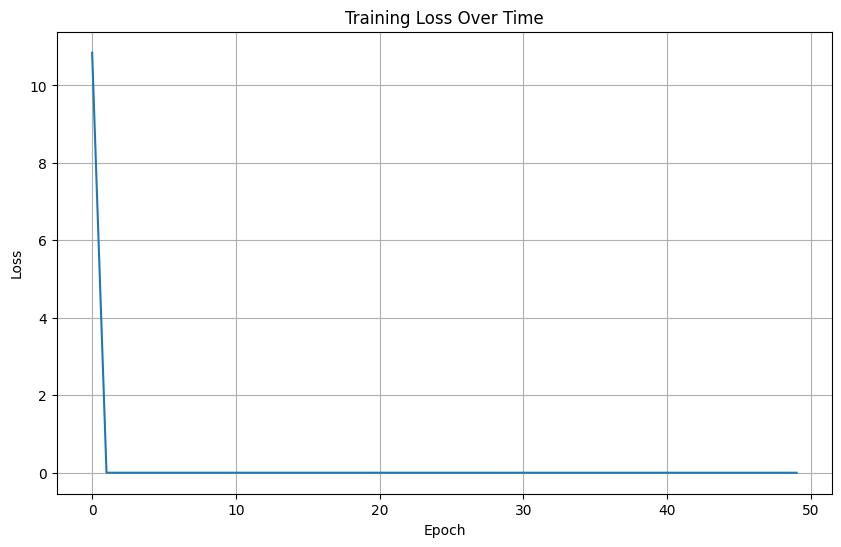

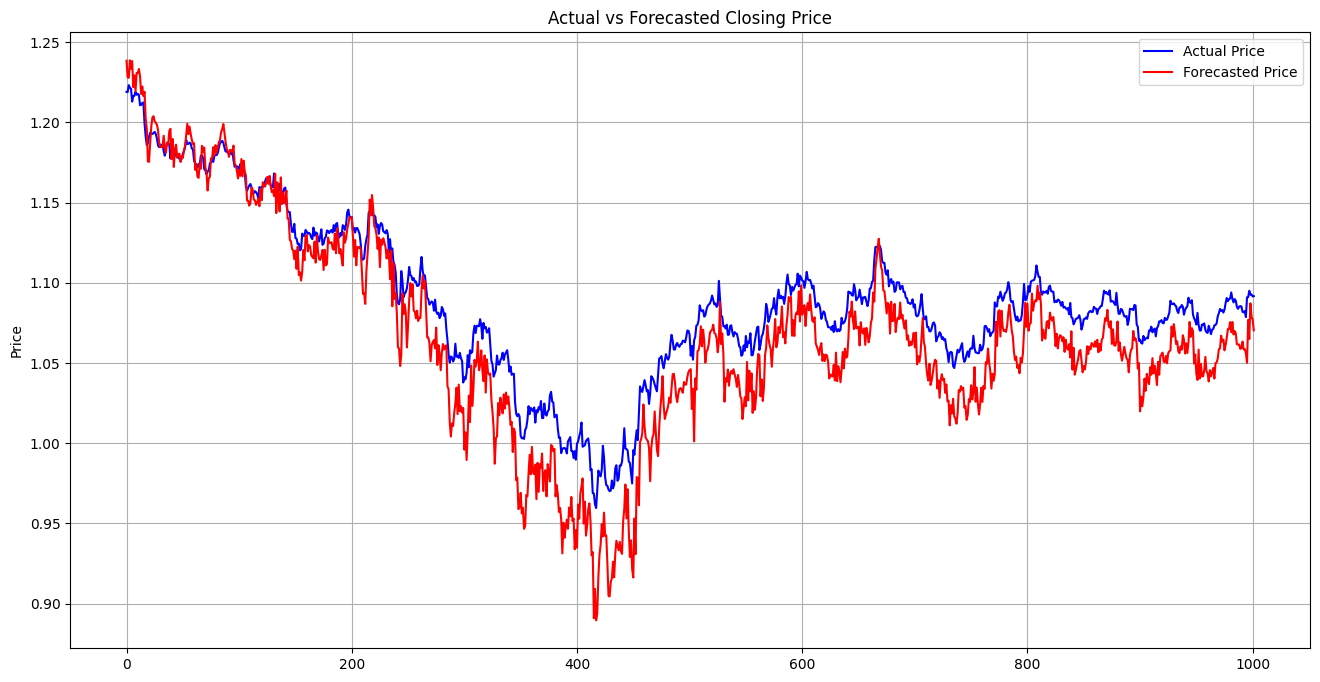

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Data Loader
class ForexDataset(Dataset):
    def __init__(self, file_path, n_past=5):
        self.data = pd.read_csv(file_path)  # Load the dataset

        self.features = []
        self.labels = []

        # Create sequences of n_past timesteps for features and the next closing price for labels
        for i in range(n_past, len(self.data)):
            self.features.append(self.data.iloc[i-n_past:i, -2].values)  # Use the previous n_past rows of the closing price
            self.labels.append(self.data.iloc[i, -2])  # The target is the closing price at the current timestep

    def __len__(self):
        return len(self.features)  # Return the number of samples
    
    def __getitem__(self, idx):
        # Convert features and labels to tensors
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feature, label

# Load the dataset
file_path = './Data/EURUSD_D1.csv'  # Replace with your actual file path
dataset = ForexDataset(file_path, 5)

# Split the dataset into training and test sets (without shuffling)
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataset, test_dataset = train_test_split(dataset,  test_size=0.2, random_state=42, shuffle=False)

print(train_dataset)

# train_dataset, test_dataset = torch.tensor(dataset[:train_size, :]), torch.tensor(dataset[train_size:, :])
print(train_dataset)
# DataLoader for batch processing (no shuffling for time series data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for batch_idx , (features,label) in enumerate(train_loader):
    print(f'batch id {batch_idx}')
    print(f'features: {features}')
    print(f'label: {label}')

# Define the Neural Network
input_size = 5  # Number of input features (n_past)
hidden_size_1 = 29  # Hidden layer 1 size (# nuerons)
hidden_size_2 = 16  # Hiden layer 2 size (# neurons)
hidden_size_3 = 8   # hidden layer 3
output_size = 1  # Output layer size (predicting the closing price)

torch.manual_seed(42)  # For reproducibility

# Initialize weights and biases for the hidden and output layers
W_hidden_1 = torch.randn(input_size, hidden_size_1, requires_grad=True)  
b_hidden_1 = torch.randn(hidden_size_1, requires_grad=True) 

W_hidden_2 = torch.randn(hidden_size_1, hidden_size_2, requires_grad=True)  
b_hidden_2 = torch.randn(hidden_size_2, requires_grad=True) 

# W_hidden_3 = torch.randn(hidden_size_2, hidden_size_3, requires_grad=True)  
# b_hidden_3 = torch.randn(hidden_size_3, requires_grad=True) 

W_output = torch.randn(hidden_size_2, output_size, requires_grad=True) 
b_output = torch.randn(output_size, requires_grad=True)  

# Activation function (ReLU)
def relu(x):
    return torch.max(torch.tensor(0.0), x)

# Loss function (Mean Squared Error)
def loss_function(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

# Forward propagation function
def forward(features):
    hidden_layer_1 = features @ W_hidden_1 + b_hidden_1  # Linear transformation (input -> hidden)
    activated_hidden_1 = relu(hidden_layer_1)  # Apply ReLU activation

    hidden_layer_2  = activated_hidden_1 @ W_hidden_2 + b_hidden_2
    activated_hidden_2 = relu(hidden_layer_2)

    output = activated_hidden_2 @ W_output + b_output  # Linear transformation (hidden -> output)
    return output

# Training the neural network
learning_rate = 0.001
num_epochs = 50

# Track loss during training
train_loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        # Forward pass
        predicted_close = forward(features)
        
        # Compute the loss
        loss = loss_function(predicted_close, labels.view(-1, 1))  # Reshape labels for compatibility
      
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update weights using gradient descent
        with torch.no_grad():
            W_hidden_1 -= learning_rate * W_hidden_1.grad
            b_hidden_1 -= learning_rate * b_hidden_1.grad

            W_hidden_2 -= learning_rate * W_hidden_2.grad
            b_hidden_2 -= learning_rate * b_hidden_2.grad

            W_output -= learning_rate * W_output.grad
            b_output -= learning_rate * b_output.grad

            # Zero the gradients after updating
            W_hidden_1.grad.zero_()
            b_hidden_1.grad.zero_()

            W_hidden_2.grad.zero_()
            b_hidden_2.grad.zero_()

            W_output.grad.zero_()
            b_output.grad.zero_()
        
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

# Plot training loss history
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Evaluate the model on the test set
actual_prices = []
predicted_prices = []

with torch.no_grad():  # Disable gradient computation during testing
    for batch_idx, (features, labels) in enumerate(test_loader):
        predicted_close = forward(features)
        actual_prices.extend(labels.tolist())  # Collect actual prices
        predicted_prices.extend(predicted_close.view(-1).tolist())  # Collect predicted prices

# Plot actual vs predicted prices
plt.figure(figsize=(16, 8))
plt.plot(actual_prices, label="Actual Price", color='blue', linestyle='-')
plt.plot(predicted_prices, label="Forecasted Price", color='red', linestyle='-')
plt.ylabel('Price')
plt.title('Actual vs Forecasted Closing Price')
plt.legend()
plt.grid(True)
plt.show()
